In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms, models, datasets
import torchvision
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import confusion_matrix
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import InterpolationMode
from collections import defaultdict


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
in_channel = 4
batch_size = 1         # Hyperparameter of GD: number of training samples used before the model parameters are updated.
learning_rate = 1e-4   # Hyperparameter of GD: amount that the weights are updated during training (step size)
num_epochs = 4         # Hyperparameter of GD: number of complete passes through the training dataset.

In [2]:
# Simple Identity class that let's input pass without changes
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [3]:
class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [4]:
# Code for undersampling or oversampling based on double the minority class sample size
class CropImage(object):
    def __init__(self, top, bottom, left, right):
        self.top = top
        self.bottom = bottom
        self.left = left
        self.right = right

    def __call__(self, img):
        return img.crop((self.left, self.top, img.width - self.right, img.height - self.bottom))

def load_data(data_dir):
    # Define your transformations for the training, validation, and testing sets
    data_transforms = transforms.Compose([ 
        transforms.ToTensor()
    ])

    # Load the datasets with ImageFolder
    image_dataset = ImageFolderWithPaths(data_dir, data_transforms)

    # Count the number of images per class and find the class with the least number of images
    class_counts = {class_name: len(os.listdir(os.path.join(data_dir, class_name))) for class_name in image_dataset.classes}
    min_samples = min(class_counts.values())
    target_samples = 1 * min_samples # Add factor here if you want to oversample minority class

    print(f"Class counts: {class_counts}")
    print(f"Target samples per class: {target_samples}")

    # Create indices for undersampling or oversampling
    indices = []
    for label in range(len(image_dataset.classes)):
        class_indices = [i for i, (path, target) in enumerate(image_dataset.samples) if target == label]
        
        if len(class_indices) < target_samples:
            print(f"Oversampling: Class {label} has {len(class_indices)} samples, less than {target_samples}")
            indices.extend(np.random.choice(class_indices, target_samples, replace=True))
        else:
            print(f"Undersampling: Class {label} has {len(class_indices)} samples, more than {target_samples}")
            indices.extend(np.random.choice(class_indices, target_samples, replace=False))

    # Create a subset based on the sampled indices
    balanced_dataset = Subset(image_dataset, indices)

    # Split the dataset into training, validation, and test sets
    total_size = len(balanced_dataset)
    val_size = test_size = int(total_size * 0.1)
    train_size = total_size - val_size - test_size

    train_dataset, val_dataset, test_dataset = random_split(balanced_dataset, [train_size, val_size, test_size])

    # Using the image datasets and the trainforms, define the dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, val_dataloader, test_dataloader, image_dataset


In [5]:
def create_model(num_classes):
    # Load pretrained model
    model = models.vgg16(pretrained=True)

    # Freeze weights of early layers
    for param in model.parameters():
        param.requires_grad = False

    # Recreate VGG16 classifier but with out_features = num_classes in the final FC layer
    model.avgpool = Identity()
    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096, bias=True), 
        nn.ReLU(inplace=True), 
        nn.Linear(4096, 4096, bias=True),
        nn.ReLU(inplace=True),
        nn.Linear(4096, num_classes, bias=True)
    )

    model = model.to(device)
    return model

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    # Initialize dictionary to store losses
    losses = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, paths in tqdm(dataloaders[phase], total=len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # Store the loss value for this epoch
            losses[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Step the learning rate scheduler and print the new learning rate after each validation phase
            if phase == 'val':
                old_lr = optimizer.param_groups[0]['lr']
                scheduler.step(epoch_loss)
                new_lr = optimizer.param_groups[0]['lr']
                if new_lr < old_lr:
                    print("Learning Rate reduced from {:.6f} to {:.6f}".format(old_lr, new_lr))

        print()

    return model, losses


In [7]:
def test_model(model, dataloader):
    model.eval()
    running_corrects = 0

    # Placeholder lists for true and predicted labels
    y_true = []
    y_pred = []

    for inputs, labels, paths in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)

        # Extend the true and predicted labels lists
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    accuracy = running_corrects.double() / len(dataloader.dataset)
    print('Test Acc: {:.4f}'.format(accuracy))

    # Return true and predicted labels for further analysis
    return y_true, y_pred

In [8]:
# Modified class weights
if __name__ == "__main__":
    data_dir = '/mnt/analysis/e17023/Adam/trainTest/' 
    num_classes = len(os.listdir(data_dir)) 

    train_dataloader, val_dataloader, test_dataloader, image_dataset = load_data(data_dir)

    model = create_model(num_classes)

    # Define class weights
    class_weights = torch.tensor([1.0, 1.0])

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    # Define the learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4)

    dataloaders = {'train': train_dataloader, 'val': val_dataloader}

    model, losses = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs)

    y_true, y_pred = test_model(model, test_dataloader)


Class counts: {'HighE': 130, 'LowE': 361}
Target samples per class: 130
Undersampling: Class 0 has 130 samples, more than 130
Undersampling: Class 1 has 361 samples, more than 130


/user/jaros/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/user/jaros/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/4


100%|██████████| 208/208 [00:56<00:00,  3.71it/s]


train Loss: 0.7326 Acc: 0.5625


100%|██████████| 26/26 [00:03<00:00,  6.58it/s]


val Loss: 0.6619 Acc: 0.8462

Epoch 2/4


100%|██████████| 208/208 [00:56<00:00,  3.68it/s]


train Loss: 0.6916 Acc: 0.5577


100%|██████████| 26/26 [00:03<00:00,  6.74it/s]


val Loss: 0.6935 Acc: 0.5000

Epoch 3/4


100%|██████████| 208/208 [00:55<00:00,  3.76it/s]


train Loss: 0.6943 Acc: 0.4952


100%|██████████| 26/26 [00:03<00:00,  6.68it/s]


val Loss: 0.6951 Acc: 0.5000

Epoch 4/4


100%|██████████| 208/208 [01:00<00:00,  3.45it/s]


train Loss: 0.6961 Acc: 0.5096


100%|██████████| 26/26 [00:03<00:00,  6.75it/s]


val Loss: 0.6937 Acc: 0.5000

Test Acc: 0.4231


In [9]:
# Save model
torch.save(model.state_dict(), './Models/Eclassifier.pth')

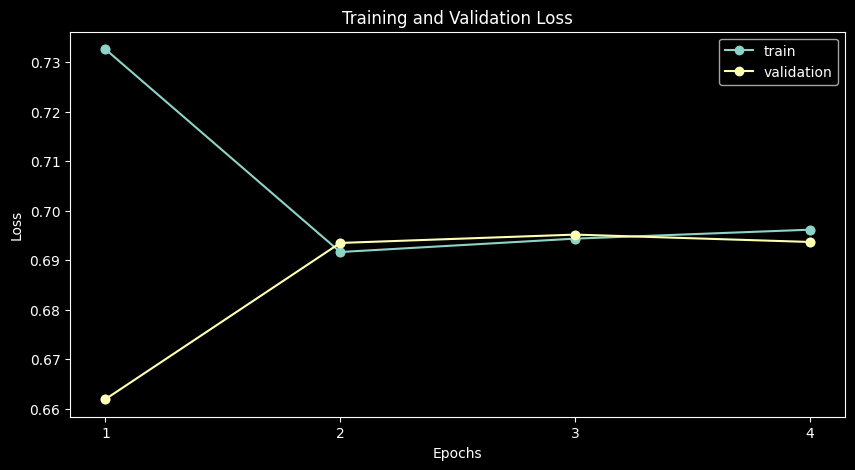

In [10]:
# Plot training and validation losses

# Create an array/list for your epochs
epochs = range(1, len(losses['train']) + 1)

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(epochs, losses['train'], label="train", marker='o')
plt.plot(epochs, losses['val'], label="validation", marker='o')
plt.scatter(epochs, losses['train'])
plt.scatter(epochs, losses['val'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # ensures x-axis shows only whole numbers
plt.show()

['HighE', 'LowE']

['HighE', 'LowE']


<Figure size 1000x700 with 0 Axes>

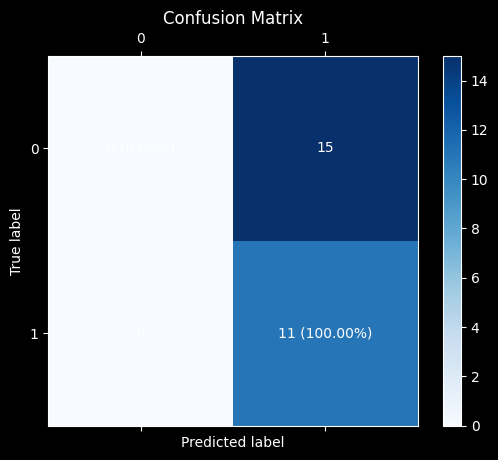

In [11]:
# Calculate the confusion matrix
""" 
Shows where the model is struggling by showing you which classes are being mistaken for others.
Especially useful when classes are imbalanced.
The perfect confusion matrix would have all its values on the main diagonal.
"""
class_names = image_dataset.classes  # get class names from dataloader
print(class_names)

cm = confusion_matrix(y_true, y_pred)

# calculate the percentage of correct predictions for each class
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_perc_diag = np.diag(cm_perc)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = class_names, columns = class_names)

# Create a new df that combines the original counts and the percentages for the diagonal
annot_df = cm_df.copy().astype(str)
np.fill_diagonal(annot_df.values, ["{} ({:.2%})".format(val, perc) for val, perc in zip(np.diag(cm_df), cm_perc_diag)])

plt.figure(figsize=(10,7))

# chatgpt replacement for sns.heatmap
def heatmap(cm_df, annot_df):
    # Assuming cm_df is your confusion matrix and annot_df is your annotation data
    cm = cm_df.to_numpy()  # Convert to numpy array if it's a pandas DataFrame
    annot = annot_df.to_numpy()  # Same for annotation

    # Create the heatmap
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap='Blues')

    # Add annotations
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{annot[i, j]}', ha='center', va='center')

    # Add colorbar
    plt.colorbar(cax)

    # Add titles and labels
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Show the plot
    plt.show()
    return None
heatmap(cm_df, annot_df)

In [12]:
def grid_images(inputs, labels, preds, class_names):
    batch_size = len(inputs)
    grid_size = int(np.ceil(np.sqrt(batch_size)))

    # If there's only one subplot, plt.subplots returns an AxesSubplot object instead of a 2D array
    # To handle this, we create a 2D array of shape (1, 1) if grid_size is 1
    if grid_size == 1:
        fig, axs = plt.subplots(1, 1, figsize=(5, 5))
        axs = np.array([[axs]])
    else:
        fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))

    # Hide axes for slots without images in the batch
    for ax in axs.flat[batch_size:]:
        ax.axis('off')

    for i, ax in enumerate(axs.flat[:batch_size]):
        ax.imshow(inputs[i].numpy().transpose((1, 2, 0)))
        ax.set_title(f'actual: {class_names[labels[i]]}\npredicted: {class_names[preds[i]]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


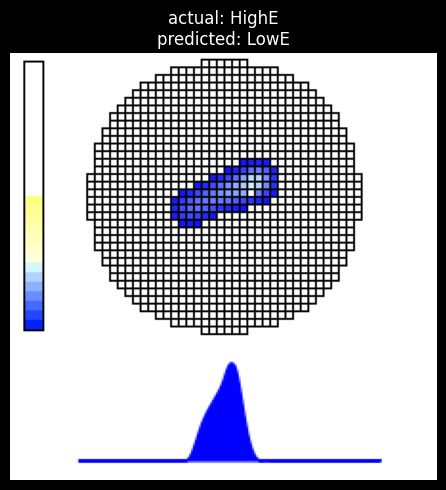

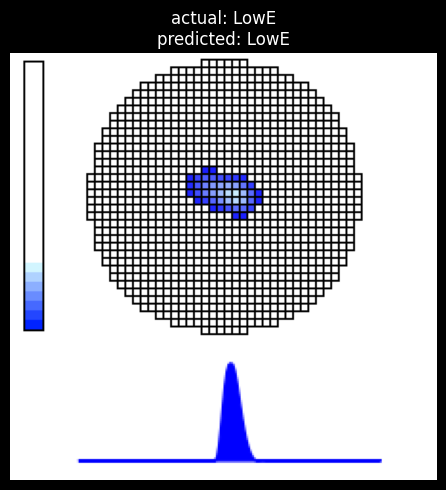

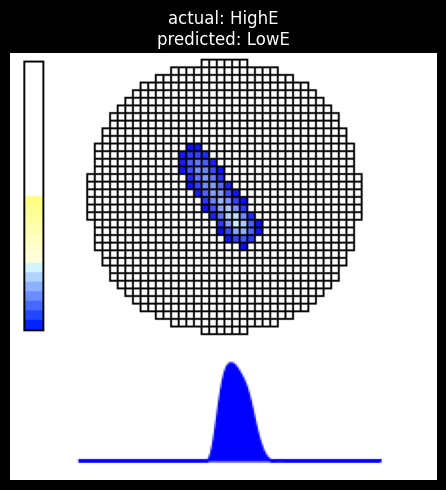

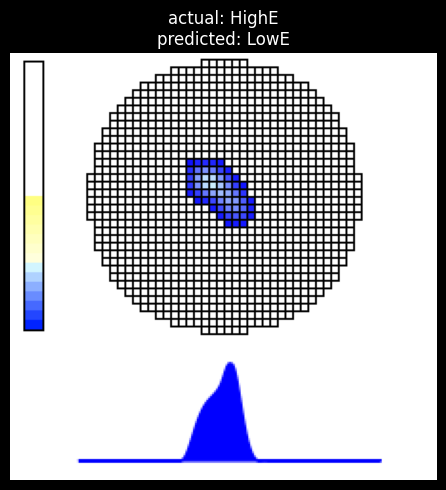

In [23]:
from PIL import Image

def imshow(inp, ax=None, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    if ax is None:
        plt.imshow(inp)
    else:
        ax.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, dataloader, class_names, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0

    # Create a transform for the original, uncropped images
    original_transform = transforms.Compose([
        transforms.ToTensor()
    ])

    with torch.no_grad():
        for i, (inputs, labels, paths) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Load the images
            original_images = torch.stack([original_transform(Image.open(path)) for path in paths])

            if images_so_far < num_images:
                grid_images(original_images, labels, preds, class_names)
                images_so_far += inputs.size(0)

            if images_so_far >= num_images:
                model.train(mode=was_training)
                return

        model.train(mode=was_training)
    

class_names = class_names = image_dataset.classes  # get class names from dataloader
visualize_model(model, val_dataloader, class_names)

In [14]:
def grid_mislabeled_images(inputs, labels, preds, class_names, paths):
    num_mislabeled = len(inputs)

    if num_mislabeled == 0:
        print("There are no mislabeled images in this batch.")
        return

    fig, axs = plt.subplots(nrows=num_mislabeled//4+1, ncols=4, figsize=(15, 5*(num_mislabeled//4+1)))

    # Hide axes for slots without images in the batch
    for i, ax in enumerate(axs.flatten()[num_mislabeled:]):
        ax.axis('off')

    # Show misclassified images
    for i, ax in enumerate(axs.flatten()[:num_mislabeled]):
        ax.imshow(inputs[i].numpy().transpose((1, 2, 0)))
        filename = os.path.basename(paths[i])  # Extract filename from path
        ax.set_title(f'{filename}\nactual: {class_names[labels[i]]}\npredicted: {class_names[preds[i]]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


All Bad Predictions


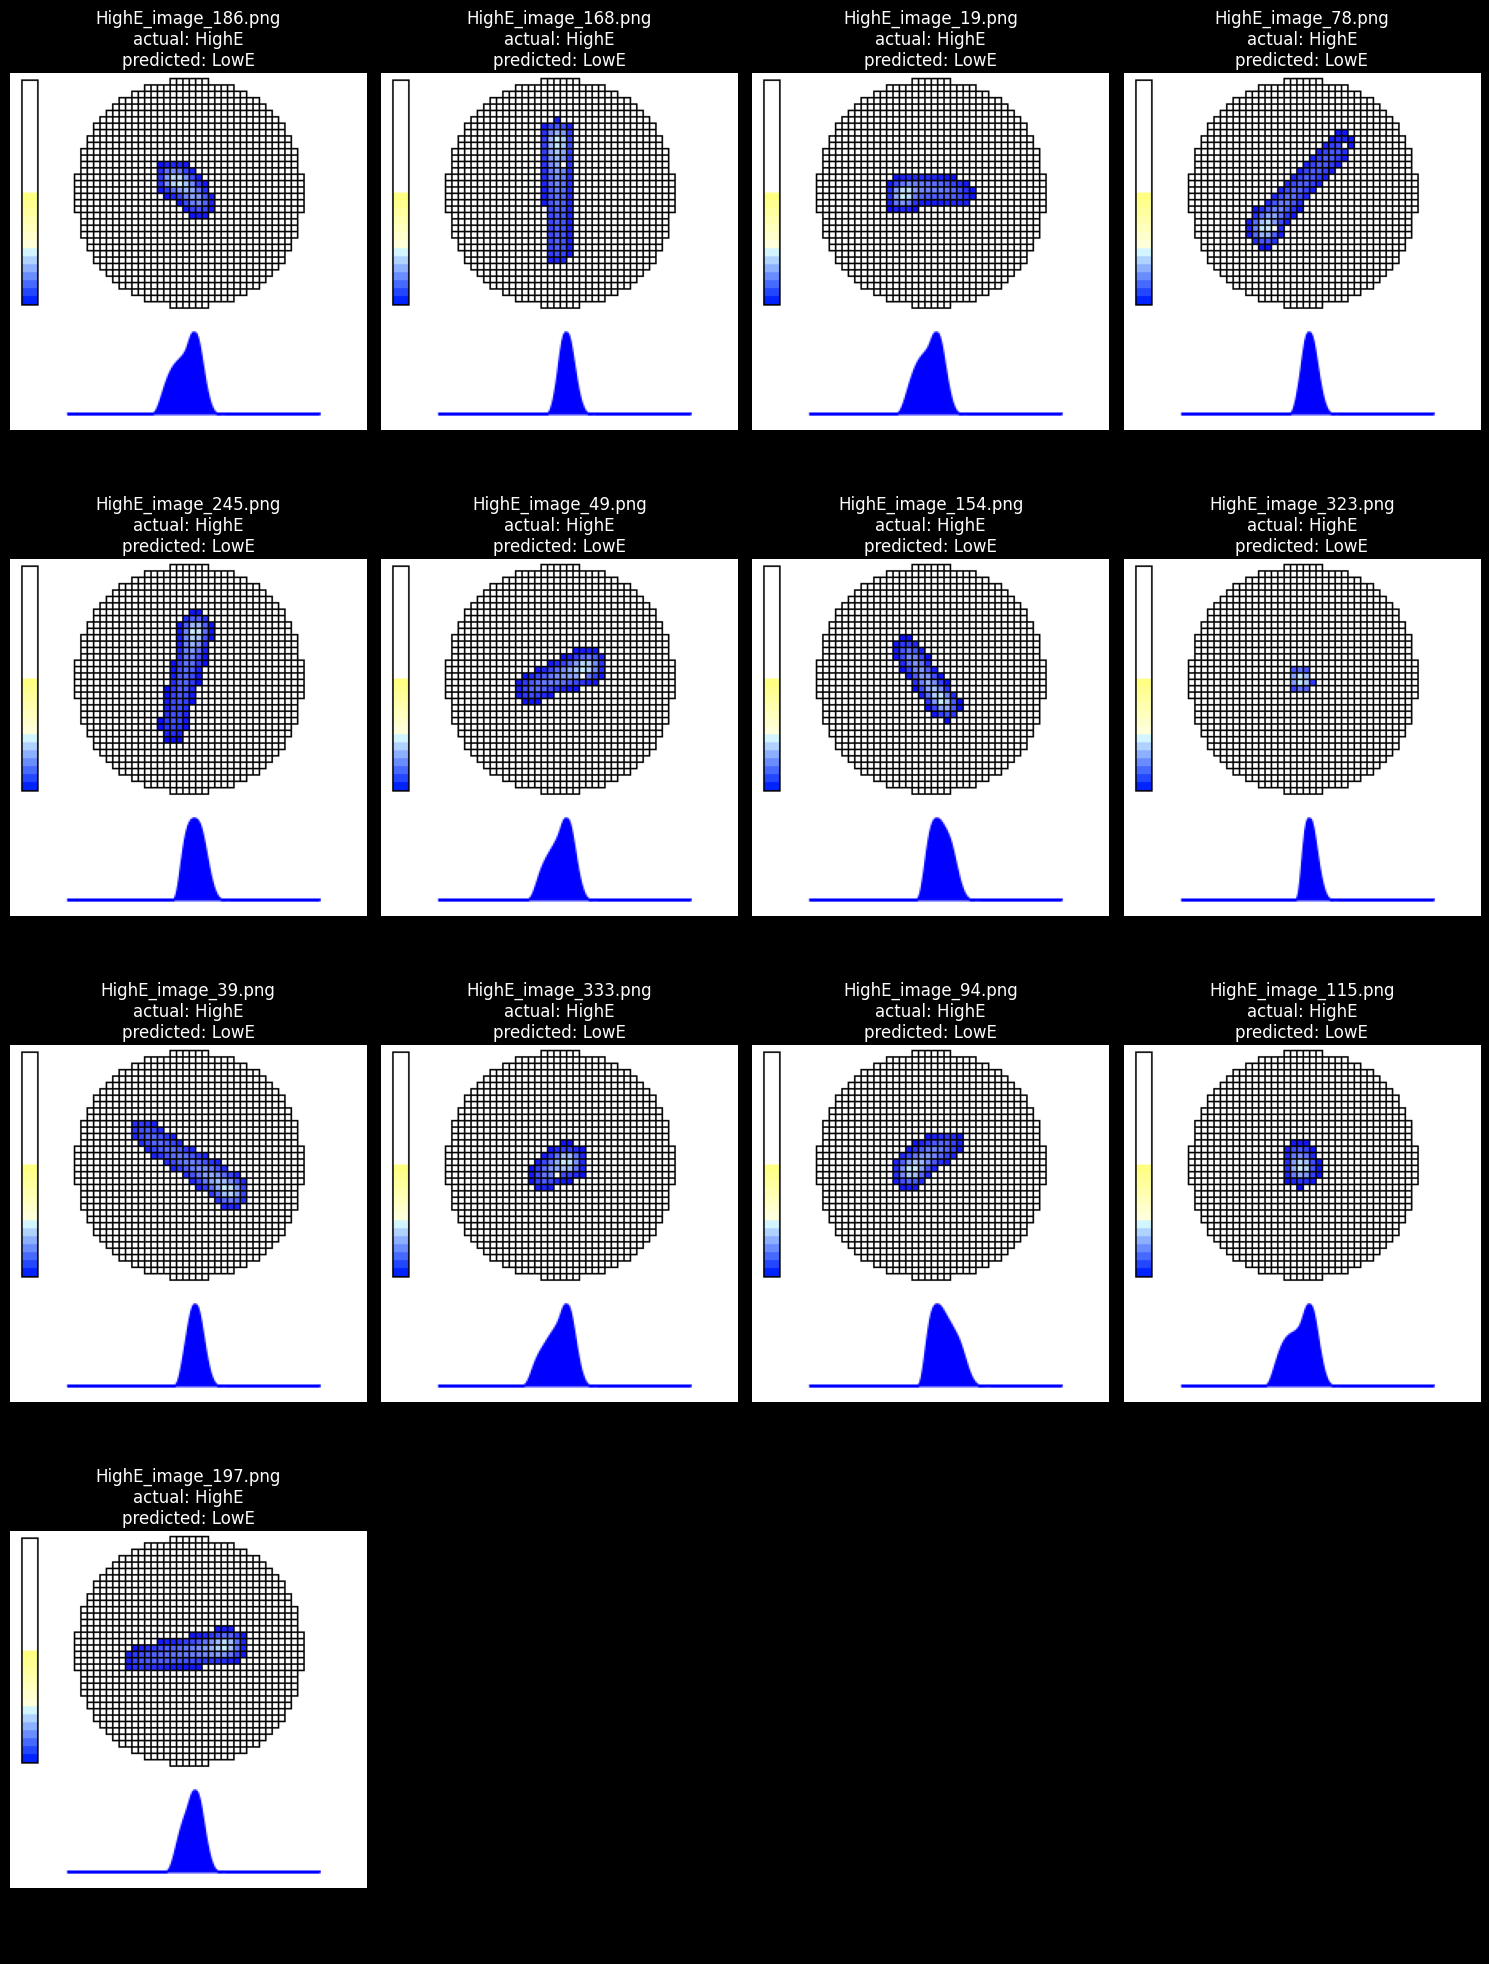

In [15]:
print('All Bad Predictions')

def imshow(inp, ax=None, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    if ax is None:
        plt.imshow(inp)
    else:
        ax.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, dataloader, class_names):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    misclassified_inputs = []
    misclassified_labels = []
    misclassified_preds = []
    misclassified_paths = []

    model.eval()
    
    # Create a transform for the original, uncropped images
    original_transform = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor()
    ])

    for inputs, labels, paths in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        misclassified_mask = preds != labels

        # Load the original, uncropped versions of the images
        original_images = torch.stack([original_transform(Image.open(path)) for path in paths])

        misclassified_inputs.extend(original_images[misclassified_mask].cpu())
        misclassified_labels.extend(labels[misclassified_mask].cpu())
        misclassified_preds.extend(preds[misclassified_mask].cpu())
        misclassified_paths.extend(np.array(paths)[np.where(misclassified_mask.cpu().numpy())[0]])

    misclassified_inputs = torch.stack(misclassified_inputs)
    misclassified_labels = torch.tensor(misclassified_labels)
    misclassified_preds = torch.tensor(misclassified_preds)
    
    if len(misclassified_inputs) > 0:
        grid_mislabeled_images(misclassified_inputs, misclassified_labels, misclassified_preds, class_names, misclassified_paths)
    else:
        print("No misclassified images.")



class_names = image_dataset.classes  # get class names from dataloader
visualize_model(model, val_dataloader, class_names)

Two-particle Bad Predictions


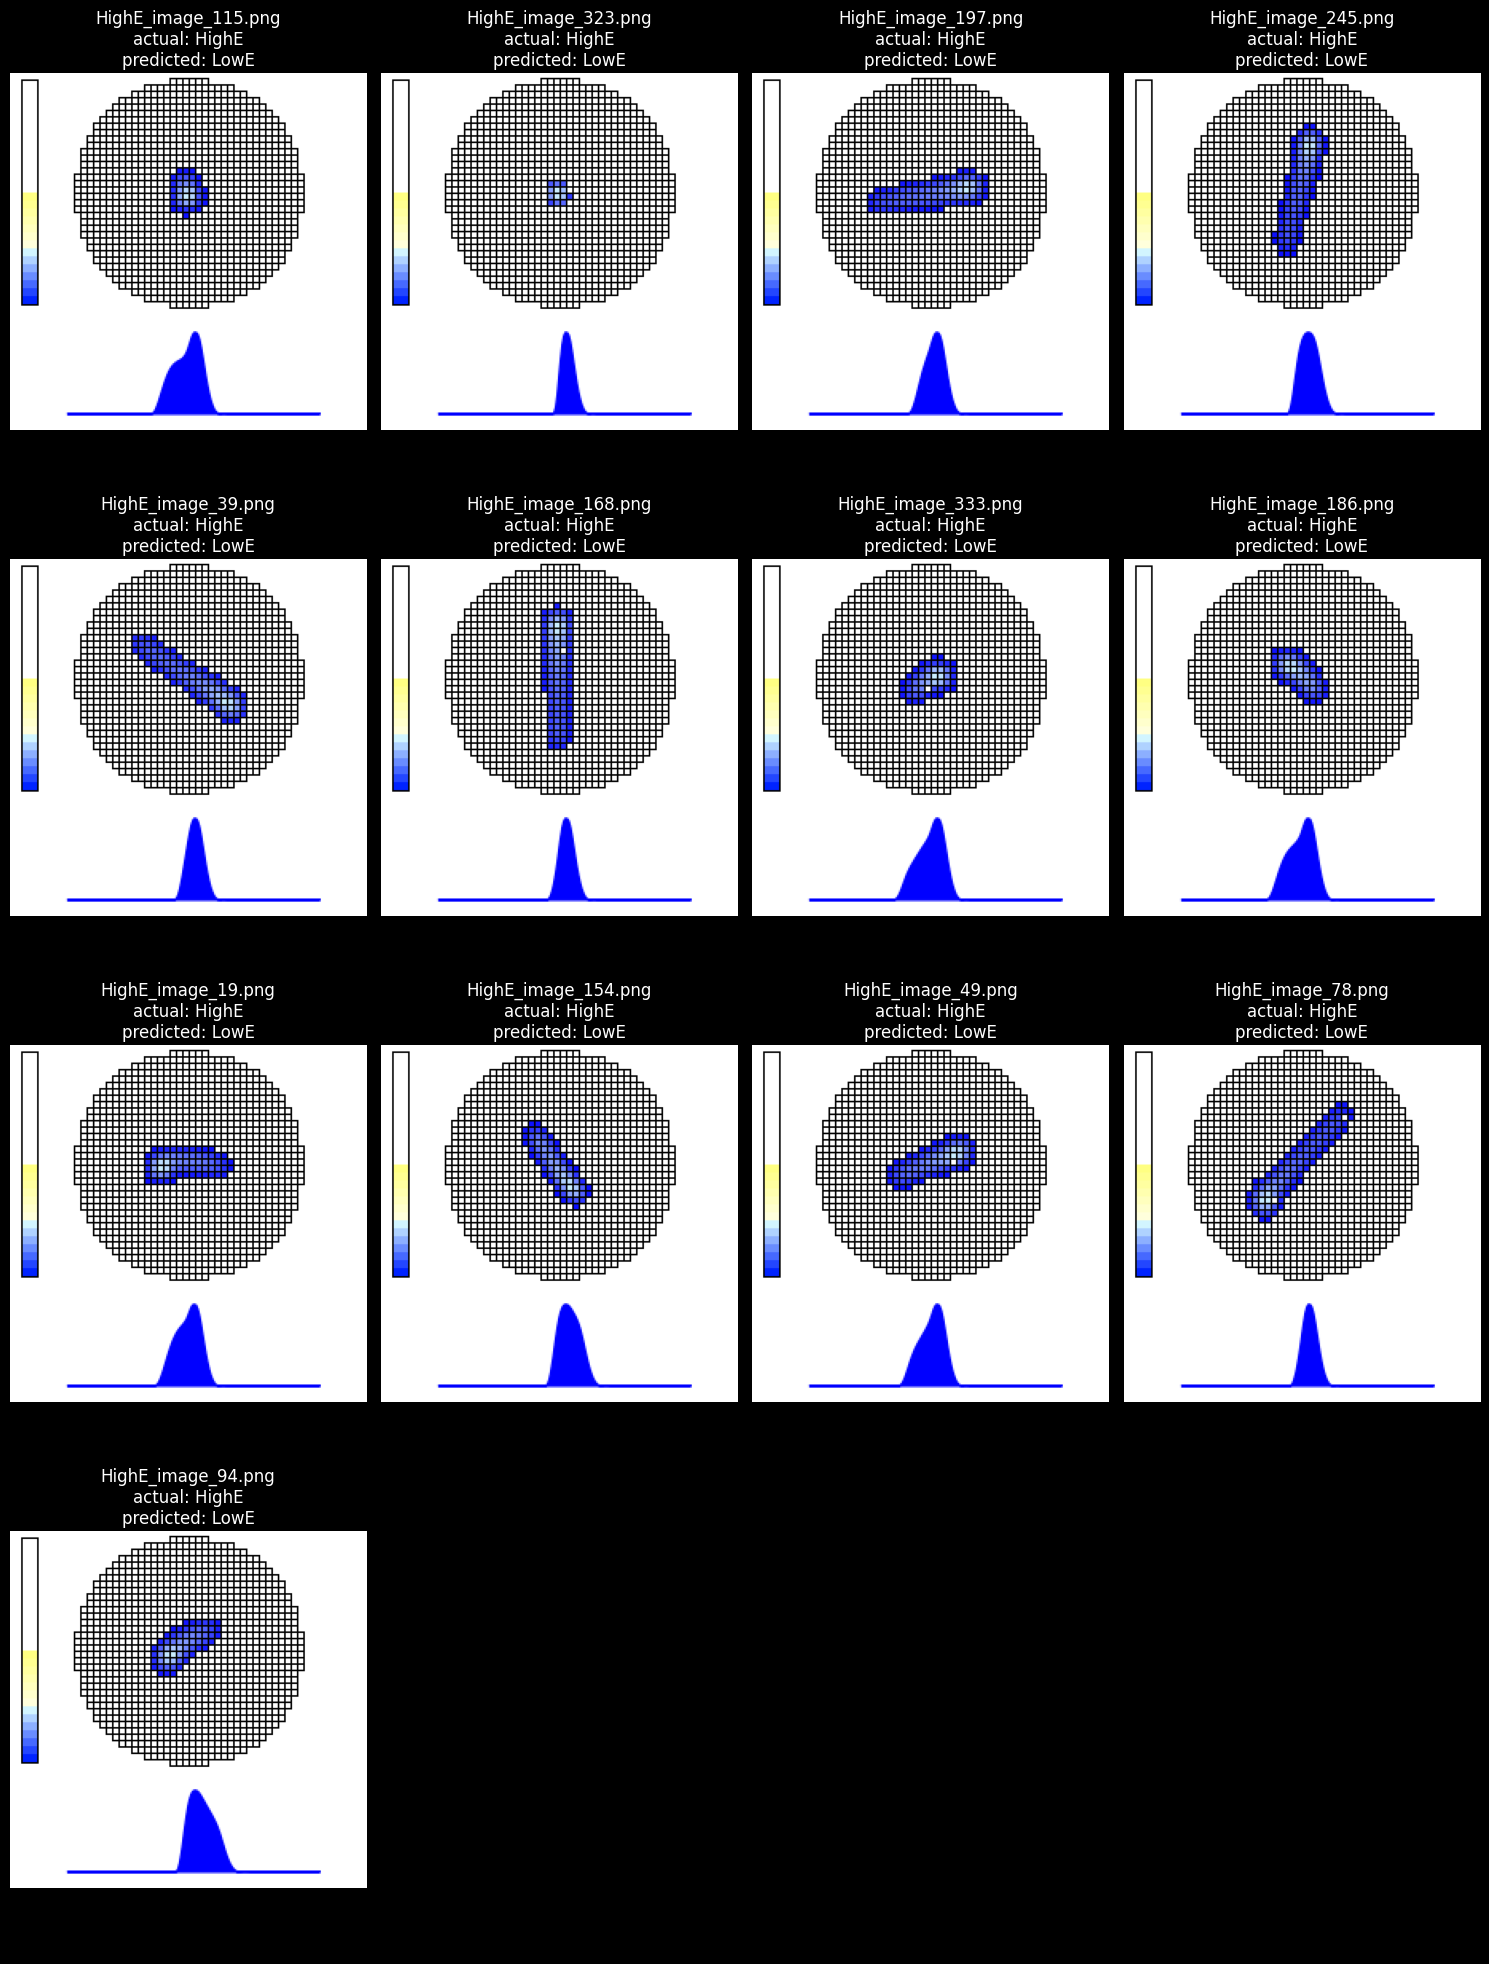

In [16]:
print('Two-particle Bad Predictions')

def visualize_model_two_particles(model, dataloader, class_names):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    misclassified_inputs = []
    misclassified_labels = []
    misclassified_preds = []
    misclassified_paths = []

    model.eval()
    
    # Create a transform for the original, uncropped images
    original_transform = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor()
    ])

    # Get the index for the 3rd class
    class_index = class_names.index('HighE') # Replace 'name_of_3rd_class' with the actual name

    for inputs, labels, paths in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # Modified misclassification mask for only the 3rd class
        misclassified_mask = (preds != labels) & (labels == class_index)

        # Load the original, uncropped versions of the images
        original_images = torch.stack([original_transform(Image.open(path)) for path in paths])

        misclassified_inputs.extend(original_images[misclassified_mask].cpu())
        misclassified_labels.extend(labels[misclassified_mask].cpu())
        misclassified_preds.extend(preds[misclassified_mask].cpu())
        misclassified_paths.extend(np.array(paths)[np.where(misclassified_mask.cpu().numpy())[0]])

    misclassified_inputs = torch.stack(misclassified_inputs)
    misclassified_labels = torch.tensor(misclassified_labels)
    misclassified_preds = torch.tensor(misclassified_preds)
    
    if len(misclassified_inputs) > 0:
        grid_mislabeled_images(misclassified_inputs, misclassified_labels, misclassified_preds, class_names, misclassified_paths)
    else:
        print("No misclassified images for the 3rd class.")

class_names = image_dataset.classes  # get class names from dataloader
visualize_model_two_particles(model, val_dataloader, class_names)

In [17]:
print('All Two-particle Correct Predictions')

def visualize_model_correct_two_particle(model, dataloader, class_names):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    correctly_classified_inputs = []
    correctly_classified_labels = []
    correctly_classified_preds = []
    correctly_classified_paths = []

    model.eval()
    
    # Create a transform for the original, uncropped images
    original_transform = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor()
    ])

    # Get the index for the class 'Two_Particle_Events'
    class_index = class_names.index('HighE')

    for inputs, labels, paths in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # Mask for correctly classified 'Two_Particle_Events' class
        correctly_classified_mask = (preds == labels) & (labels == class_index)

        # Load the original, uncropped versions of the images
        original_images = torch.stack([original_transform(Image.open(path)) for path in paths])

        correctly_classified_inputs.extend(original_images[correctly_classified_mask].cpu())
        correctly_classified_labels.extend(labels[correctly_classified_mask].cpu())
        correctly_classified_preds.extend(preds[correctly_classified_mask].cpu())
        correctly_classified_paths.extend(np.array(paths)[np.where(correctly_classified_mask.cpu().numpy())[0]])

    correctly_classified_inputs = torch.stack(correctly_classified_inputs)
    correctly_classified_labels = torch.tensor(correctly_classified_labels)
    correctly_classified_preds = torch.tensor(correctly_classified_preds)
    
    if len(correctly_classified_inputs) > 0:
        grid_mislabeled_images(correctly_classified_inputs, correctly_classified_labels, correctly_classified_preds, class_names, correctly_classified_paths)
    else:
        print("No correctly classified images for 'Two_Particle_Events' class.")

class_names = image_dataset.classes  # get class names from dataloader
visualize_model_correct_two_particle(model, val_dataloader, class_names)


All Two-particle Correct Predictions


RuntimeError: stack expects a non-empty TensorList

In [ ]:
model.eval()
img = next(iter(val_dataloader))
img[2]

('/mnt/analysis/e17023/Adam/trainTest/HighE/HighE_image_286.png',
 '/mnt/analysis/e17023/Adam/trainTest/LowE/LowE_image_115.png',
 '/mnt/analysis/e17023/Adam/trainTest/LowE/LowE_image_190.png',
 '/mnt/analysis/e17023/Adam/trainTest/HighE/HighE_image_292.png')